In [1]:
import json

with open("rag_truth_train2.json", "r") as f:
    train_data = json.load(f)
with open("rag_truth_dev.json", "r") as f:
    dev_data = json.load(f)
with open("rag_truth_test.json", "r") as f:
    test_data = json.load(f)

In [2]:
# prefixをつける
def add_prefix(data):
    for d in data:
        d["text"] = "Please judge the following statement as true or false based on the references above: " + d["text"]
    return data

train_data = add_prefix(train_data)
dev_data = add_prefix(dev_data)
test_data = add_prefix(test_data)

In [3]:
# task_type: QA, Data2txt, Summary
task_name = "Summary"
train_data = [d for d in train_data if d["task_type"] == task_name]
dev_data = [d for d in dev_data if d["task_type"] == task_name]
test_data = [d for d in test_data if d["task_type"] == task_name]

In [3]:
from datasets import Dataset, DatasetDict
import pandas as pd

train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)
train_ds = Dataset.from_pandas(train_df)
dev_ds = Dataset.from_pandas(dev_df)
test_ds = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({"train": train_ds, "dev":dev_ds, "test": test_ds})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 13830
    })
    dev: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 2700
    })
})

In [4]:
from transformers import AutoTokenizer, DataCollatorWithPadding


tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
#tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large",use_fast=False)

def tokenize_function(examples):
    ref = tokenizer(examples["ref"],truncation=True, max_length=512)
    text = tokenizer(examples["text"],truncation=True, max_length=512)
    return {
        "ref_input_ids":ref["input_ids"],
        "ref_attention_mask":ref["attention_mask"],
        "text_input_ids":text["input_ids"],
        "text_attention_mask":text["attention_mask"],
    }

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text","ref"])
#tokenized_datasets.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

2024-12-26 14:16:40.731218: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-26 14:16:40.743538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-26 14:16:40.759486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-26 14:16:40.759516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 14:16:40.771672: I tensorflow/core/platform/cpu_feature_gua

Map:   0%|          | 0/13830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

In [5]:
from transformers import DataCollatorWithPadding
from torch.nn.utils.rnn import pad_sequence
import torch

class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # features の例: [{'anchor_input_ids': ..., 'anchor_attention_mask': ..., ...}, ...]
        
        # データのリストを作成
        ref_ids = [torch.tensor(x['ref_input_ids']) for x in features]
        text_ids = [torch.tensor(x['text_input_ids']) for x in features]
       
        
        ref_mask = [torch.tensor(x['ref_attention_mask']) for x in features]
        text_mask = [torch.tensor(x['text_attention_mask']) for x in features]
        labels = torch.tensor([x['labels'] for x in features])
        
        # パディング処理
        ref_ids = pad_sequence(ref_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        text_ids = pad_sequence(text_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        
        ref_mask = pad_sequence(ref_mask, batch_first=True, padding_value=0)
        text_mask = pad_sequence(text_mask, batch_first=True, padding_value=0)
        
        # バッチ辞書を作成
        batch = {
            "input_ids": [ref_ids, text_ids],
            "attention_mask": [ref_mask, text_mask],
            "labels": labels
        }
        
        return batch


data_collator = CustomDataCollator(tokenizer=tokenizer)

In [6]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'source', 'model', 'task_type', 'source_id', 'ref_input_ids', 'ref_attention_mask', 'text_input_ids', 'text_attention_mask'],
        num_rows: 13830
    })
    dev: Dataset({
        features: ['labels', 'source', 'model', 'task_type', 'source_id', 'ref_input_ids', 'ref_attention_mask', 'text_input_ids', 'text_attention_mask'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['labels', 'source', 'model', 'task_type', 'source_id', 'ref_input_ids', 'ref_attention_mask', 'text_input_ids', 'text_attention_mask'],
        num_rows: 2700
    })
})

In [8]:
from transformers import AutoModel

#tri_model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/RoBERTa-base", num_labels=2)
base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")
#base_model = AutoModel.from_pretrained("vinai/bertweet-large")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
import torch

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#base_model = torch.compile(base_model)
base_model.to(device)
device

device(type='cuda')

In [10]:
import torch
import torch.nn as nn
from transformers.modeling_outputs import ModelOutput
import os

loss_list = []
class RagModel(nn.Module):
    def __init__(self, base_model, question_encoder=None, generator=None):
        super(RagModel, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.1) 
        #self.classifier = nn.Linear(base_model.config.hidden_size * 2, 2)  # ラベル予測用の分類層
        self.classifier = nn.Linear(base_model.config.hidden_size, 2)  # ラベル予測用の分類層
        self.question_encoder = question_encoder
        self.generator = generator

    def forward(
        self,
        input_ids,
        attention_mask = None,
        labels = None
    ):
        
        ref_input_ids = input_ids[0]
        text_input_ids = input_ids[1]
        ref_attention_mask = attention_mask[0]
        text_attention_mask = attention_mask[1]
        #print(ref_input_ids,ref_attention_mask)

        
        #ref_output = self.base_model(input_ids=ref_input_ids, attention_mask=ref_attention_mask)[0][:,-1,:]
        #text_output = self.base_model(input_ids=text_input_ids, attention_mask=text_attention_mask)[0][:,-1,:]
        output = self.base_model(input_ids=torch.cat([ref_input_ids, text_input_ids], dim=1), attention_mask=torch.cat([ref_attention_mask, text_attention_mask], dim=1))[0][:,-1,:]
        #output = output.mean(dim=1)
        #print(output.shape)  # 出力の形状を確認
        
        #ref_output = self.dropout(ref_output)
        #text_output = self.dropout(text_output)
        output = self.dropout(output)

        # ラベル予測の出力
        #logits = self.classifier(torch.cat([ref_output, text_output], dim=1))
        logits = self.classifier(output)

        loss = nn.CrossEntropyLoss()(logits, labels) if labels is not None else None
        loss_list.append(loss)

        return ModelOutput(logits=logits, loss=loss)
        #return ModelOutput(loss=loss)

    def save_pretrained(self, save_directory):
        """
        モデル全体とサブモジュールを保存するカスタムメソッド
        """
        os.makedirs(save_directory, exist_ok=True)

        # サブモジュールの保存
        if self.question_encoder is not None:
            self.question_encoder.save_pretrained(os.path.join(save_directory, "question_encoder"))
        if self.generator is not None:
            self.generator.save_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みを保存
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

    @classmethod
    def from_pretrained(cls, save_directory):
        """
        保存済みモデルをロードするカスタムメソッド
        """
        question_encoder = None
        generator = None

        # サブモジュールのロード
        if os.path.exists(os.path.join(save_directory, "question_encoder")):
            question_encoder = AutoModel.from_pretrained(os.path.join(save_directory, "question_encoder"))
        if os.path.exists(os.path.join(save_directory, "generator")):
            generator = AutoModel.from_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みをロード
        model = cls(question_encoder=question_encoder, generator=generator)
        model.load_state_dict(torch.load(os.path.join(save_directory, "pytorch_model.bin")))

        return model

In [7]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1).tolist()  # ndarray をリストに変換
    labels = labels.tolist()  # ndarray をリストに変換
    
    # accuracy と f1 score を計算
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions)
    precision = precision_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

In [8]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModel, RobertaForSequenceClassification
import torch
from torch.nn.parallel import DataParallel
from models import RagModel

base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")
# モデルとトークナイザーを読み込む
name = "./1216_rag"
model = RagModel.from_pretrained(base_model, name)
#tokenizer = AutoTokenizer.from_pretrained(name)

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

#training_args = TrainingArguments("test-trainer")
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="steps",  
    save_steps=10000,
    learning_rate=1e-6,
    per_device_train_batch_size=4,#4
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16 = True,
    gradient_accumulation_steps=12,#12
    logging_dir="./logs",
    remove_unused_columns=False,
    report_to="tensorboard",
    #torch_compile = True,
    #gradient_checkpointing=True,
    optim="adafactor",
)

#model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)
#model = RagModel(base_model)
#model = torch.compile(model)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/19265.1.interactive/ipykernel_834025/82439839.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

{'eval_loss': 0.9903844594955444,
 'eval_model_preparation_time': 0.0034,
 'eval_accuracy': 0.8107407407407408,
 'eval_recall': 0.7582184517497349,
 'eval_precision': 0.7164328657314629,
 'eval_f1': 0.7367336424523442,
 'eval_runtime': 123.266,
 'eval_samples_per_second': 21.904,
 'eval_steps_per_second': 5.476}

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Recall,Precision,F1
0,0.568800,0.472544,0.004100,0.791270,0.654206,0.817757,0.726895
1,0.463500,0.446236,0.004100,0.795238,0.609346,0.869333,0.716484
2,0.376300,0.408194,0.004100,0.820635,0.783178,0.792060,0.787594
3,0.275100,0.436989,0.004100,0.830952,0.736449,0.845494,0.787213
4,0.189100,0.489936,0.004100,0.820635,0.788785,0.788785,0.788785
6,0.069700,0.674423,0.004100,0.814286,0.777570,0.783427,0.780488
7,0.045700,0.806210,0.004100,0.815079,0.762617,0.793774,0.777884
8,0.035100,0.892604,0.004100,0.823016,0.779439,0.798851,0.789026
9,0.023100,0.962215,0.004100,0.818254,0.771963,0.794231,0.782938


TrainOutput(global_step=2880, training_loss=0.216921124027835, metrics={'train_runtime': 12269.7471, 'train_samples_per_second': 11.272, 'train_steps_per_second': 0.235, 'total_flos': 0.0, 'train_loss': 0.216921124027835, 'epoch': 9.994216310005784})

In [15]:
# トレーニング後にモデルを保存
name = "./1216_rag"
trainer.save_model(name)
trainer.save_state()
model.save_pretrained(name)

In [11]:
def create_dev_task(name):
    dev_data2 = [d for d in test_data if d["task_type"] == name]
    dev_df2 = pd.DataFrame(dev_data2)
    dev_ds2 = Dataset.from_pandas(dev_df2)
    tokenized_datasets_task = dev_ds2.map(tokenize_function, batched=True)
    tokenized_datasets_task = tokenized_datasets_task.remove_columns(["text","ref"])
    return tokenized_datasets_task

In [12]:
dev_qa = create_dev_task("QA")
trainer.evaluate(eval_dataset=dev_qa)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'eval_loss': 0.613818883895874,
 'eval_model_preparation_time': 0.0034,
 'eval_accuracy': 0.8633333333333333,
 'eval_recall': 0.64375,
 'eval_precision': 0.6094674556213018,
 'eval_f1': 0.6261398176291794,
 'eval_runtime': 37.2951,
 'eval_samples_per_second': 24.132,
 'eval_steps_per_second': 6.033}

In [13]:
dev_d2t = create_dev_task("Data2txt")
trainer.evaluate(eval_dataset=dev_d2t)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'eval_loss': 1.0657926797866821,
 'eval_model_preparation_time': 0.0034,
 'eval_accuracy': 0.8133333333333334,
 'eval_recall': 0.8894645941278065,
 'eval_precision': 0.8319870759289176,
 'eval_f1': 0.8597662771285476,
 'eval_runtime': 46.5953,
 'eval_samples_per_second': 19.315,
 'eval_steps_per_second': 4.829}

In [14]:
dev_sum = create_dev_task("Summary")
trainer.evaluate(eval_dataset=dev_sum)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'eval_loss': 1.2915420532226562,
 'eval_model_preparation_time': 0.0034,
 'eval_accuracy': 0.7555555555555555,
 'eval_recall': 0.47549019607843135,
 'eval_precision': 0.46190476190476193,
 'eval_f1': 0.46859903381642515,
 'eval_runtime': 39.6324,
 'eval_samples_per_second': 22.709,
 'eval_steps_per_second': 5.677}

In [21]:
loss_list = [x.item() for x in loss_list]

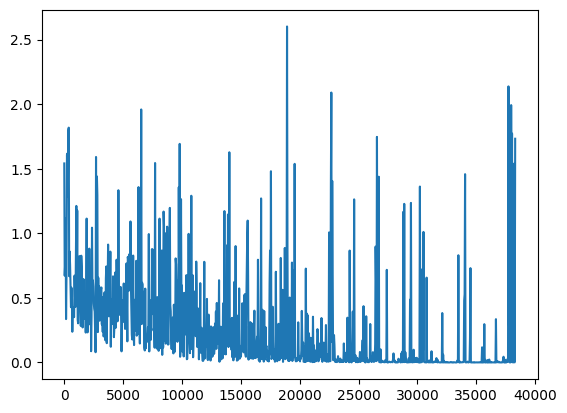

In [22]:
import matplotlib.pyplot as plt

x = np.arange(0,len(loss_list),len(loss_list)//1000)
loss_list = np.array(loss_list)
plt.plot(x,loss_list[x])
plt.show()

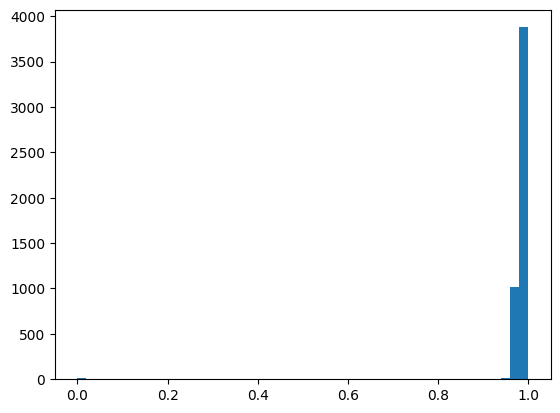

In [11]:
import matplotlib.pyplot as plt
plt.hist(sim_max_list,bins = 50)
plt.show()

In [1]:
 !nvidia-smi

Tue Nov 26 17:05:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100                    On  |   00000000:E4:00.0 Off |                    0 |
| N/A   27C    P0             70W /  699W |       1MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [16]:
import torch
torch.cuda.empty_cache() 

In [18]:
from transformers import AutoModel
from transformers import AutoTokenizer, DataCollatorWithPadding
import torch
"""
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")


# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
base_model.to(device)
"""
text = "I have a pen too"
tokenized_text = tokenizer(text)
ref = "It is mine"
tokenized_ref = tokenizer(ref)

# トークン化された結果の確認
#print(tokenized_text)

# input_ids と attention_mask を Tensor に変換
input_ids = torch.tensor(tokenized_text['input_ids']).unsqueeze(0).to(device)  # バッチ次元を追加
attention_mask = torch.tensor(tokenized_text['attention_mask']).unsqueeze(0).to(device)
ref_input_ids = torch.tensor(tokenized_ref['input_ids']).unsqueeze(0).to(device)  # バッチ次元を追加
ref_attention_mask = torch.tensor(tokenized_ref['attention_mask']).unsqueeze(0).to(device)

# モデルに渡す
output = base_model(input_ids=torch.cat([ref_input_ids, input_ids], dim=1).to(device),
                     attention_mask=torch.cat([ref_attention_mask, attention_mask], dim=1).to(device))

print(output[0])

tensor([[[ 0.7937,  2.3709,  0.0817,  ...,  1.4969,  2.4246, -0.3665],
         [-0.1951,  0.8535,  0.5683,  ..., -0.5551, -0.3085, -1.5081],
         [ 0.4363,  0.7816,  0.5234,  ...,  0.0432,  0.4365, -1.1846],
         ...,
         [-0.2996,  1.0239,  0.8568,  ...,  0.0313, -0.1460, -0.9475],
         [-0.3633,  0.8118,  0.2737,  ...,  1.3980, -0.1770, -0.4305],
         [-0.2807,  1.0537,  0.7372,  ...,  0.3722, -0.0164, -0.3544]]],
       device='cuda:0', grad_fn=<MulBackward0>)


In [1]:
!nvidia-smi

Mon Dec 16 15:33:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100                    On  | 00000000:04:00.0 Off |                    0 |
| N/A   25C    P0              68W / 699W |      4MiB / 95830MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--